# Setting Up

In [ ]:
#importing all necessary libraries
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.applications import VGG16

In [ ]:
#data from drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Main directory containing 'healthy' and 'unhealthy'
data_dir = '/content/drive/My Drive/cs156-data'


In [ ]:
#paths in the directory
train_dir = os.path.join(data_dir, 'train')
validation_dir = os.path.join(data_dir, 'val')
test_dir = os.path.join(data_dir, 'test')

In [ ]:
import os

# Define paths to directories
categories = ["healthy", "unhealthy"]
splits = ["train", "test", "validation"]

# Initialize counters
category_counts = {category: 0 for category in categories}

# Loop through splits and categories
for split in splits:
    for category in categories:
        category_dir = os.path.join(data_dir, split, category)
        if os.path.exists(category_dir):  # Check if the directory exists
            # Count the number of files in the category directory
            count = len([f for f in os.listdir(category_dir) if os.path.isfile(os.path.join(category_dir, f))])
            category_counts[category] += count

# Print the results
for category, count in category_counts.items():
    print(f"Total {category} images: {count}")


Total healthy images: 1224
Total unhealthy images: 1224


In [ ]:
#defining the batch size
BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)
test_dataset = tf.keras.utils.image_dataset_from_directory(test_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 2142 files belonging to 2 classes.
Found 612 files belonging to 2 classes.
Found 306 files belonging to 2 classes.


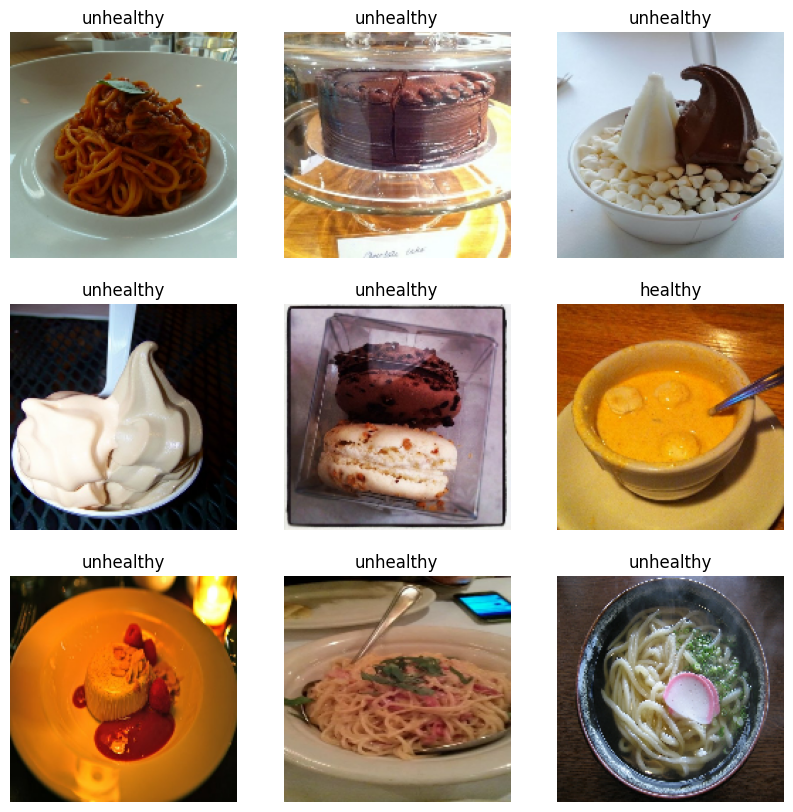

In [ ]:
#visualizing images
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

# Part 1: Evaluating Previous Models with Data Augmentation

## Data Augmentation

In [ ]:
# Define the data augmentation pipeline
data_augmentation = tf.keras.Sequential([
    # Flip images horizontally and vertically
    tf.keras.layers.RandomFlip('horizontal_and_vertical'),

    # Rotate images randomly by 20% of 360 degrees
    tf.keras.layers.RandomRotation(0.2),

    # Zoom in and out randomly
    tf.keras.layers.RandomZoom(height_factor=(-0.2, 0.2), width_factor=(-0.2, 0.2)),

    # Translate images randomly in height and width directions
    tf.keras.layers.RandomTranslation(height_factor=0.2, width_factor=0.2),

    # Adjust brightness randomly
    tf.keras.layers.RandomBrightness(factor=0.2),

    # Adjust contrast randomly
    tf.keras.layers.RandomContrast(factor=0.2),

    # Add Gaussian noise to images
    tf.keras.layers.GaussianNoise(stddev=0.1)
])

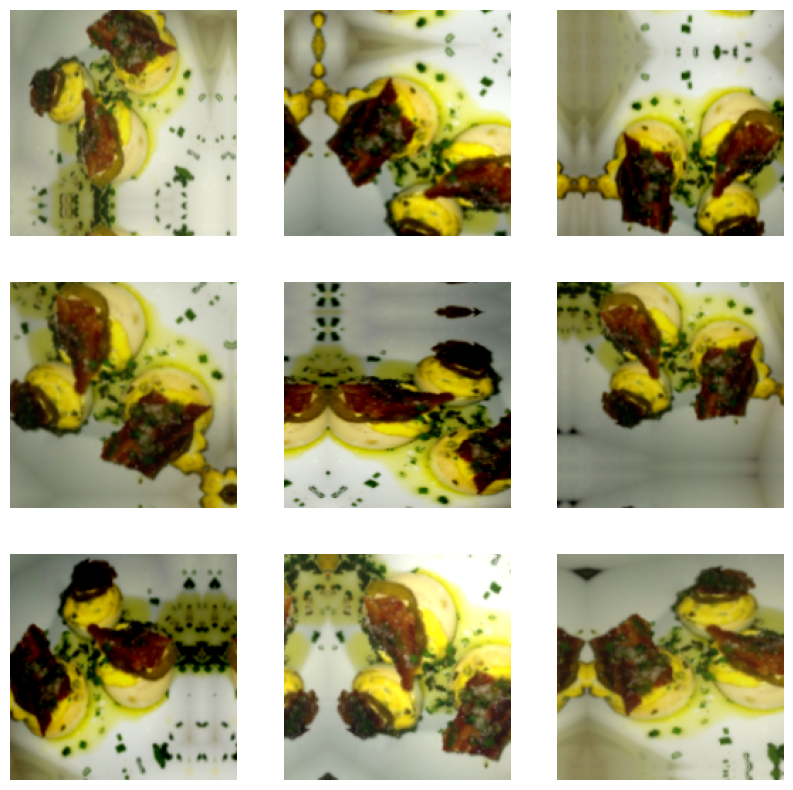

In [ ]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

#

## Logistic Regression

In [ ]:
# Prepare features and labels
def preprocess_dataset(dataset, augment=False):
    features = []
    labels = []
    for batch, label_batch in dataset:
        if augment:  # Apply augmentation only for the training dataset
            batch = data_augmentation(batch)
        for img, label in zip(batch, label_batch):
            # Flatten and normalize images
            flattened_img = tf.reshape(img, [-1]) / 255.0
            features.append(flattened_img.numpy())
            labels.append(label.numpy())
    return np.array(features), np.array(labels)

# Preprocess datasets
X_train, y_train = preprocess_dataset(train_dataset, augment=True)
X_val, y_val = preprocess_dataset(validation_dataset, augment=False)
X_test, y_test = preprocess_dataset(test_dataset, augment=False)


In [ ]:
# Train Logistic Regression
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)

# Evaluate the model on the test dataset
y_pred = log_reg.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.2f}")

Test Accuracy: 0.56


              precision    recall  f1-score   support

           0       0.55      0.61      0.58       153
           1       0.57      0.51      0.54       153

    accuracy                           0.56       306
   macro avg       0.56      0.56      0.56       306
weighted avg       0.56      0.56      0.56       306

Confusion Matrix:
[[93 60]
 [75 78]]
Classification Report:
              precision    recall  f1-score   support

           0       0.55      0.61      0.58       153
           1       0.57      0.51      0.54       153

    accuracy                           0.56       306
   macro avg       0.56      0.56      0.56       306
weighted avg       0.56      0.56      0.56       306



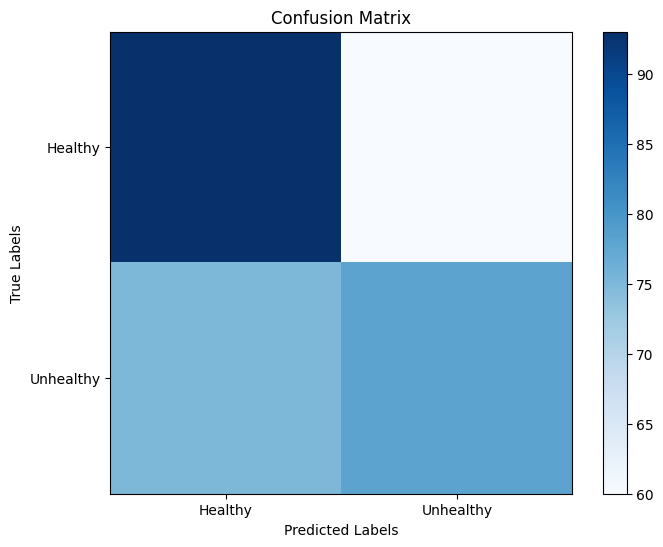

In [ ]:
report = classification_report(y_test, y_pred)
print(report)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, cmap='Blues', interpolation='nearest')
plt.title("Confusion Matrix")
plt.colorbar()
plt.xticks(np.arange(2), labels=['Healthy', 'Unhealthy'])
plt.yticks(np.arange(2), labels=['Healthy', 'Unhealthy'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


## SVM

In [ ]:
# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize the SVM model
svm_model = SVC(kernel='linear', C=1, gamma = 'scale',max_iter=5000)

# Train the SVM model
svm_model.fit(X_train_scaled, y_train)

# Evaluate the model
y_pred = svm_model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy with SVM: {accuracy:.2f}")

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Test Accuracy with SVM: 0.58


In [ ]:
#kernel = rbf
svm_model = SVC(kernel='rbf', C=1, gamma = 'scale',max_iter=5000)

# Train the SVM model
svm_model.fit(X_train_scaled, y_train)

# Evaluate the model
y_pred = svm_model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy with SVM: {accuracy:.2f}")

Test Accuracy with SVM: 0.59


In [ ]:
#kernel = rbf
svm_model = SVC(kernel='poly', C=1, gamma = 'scale',max_iter=5000)

# Train the SVM model
svm_model.fit(X_train_scaled, y_train)

# Evaluate the model
y_pred = svm_model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy with SVM: {accuracy:.2f}")

Test Accuracy with SVM: 0.60


              precision    recall  f1-score   support

           0       0.59      0.71      0.64       153
           1       0.63      0.50      0.56       153

    accuracy                           0.60       306
   macro avg       0.61      0.60      0.60       306
weighted avg       0.61      0.60      0.60       306

Confusion Matrix:
[[108  45]
 [ 76  77]]
Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.71      0.64       153
           1       0.63      0.50      0.56       153

    accuracy                           0.60       306
   macro avg       0.61      0.60      0.60       306
weighted avg       0.61      0.60      0.60       306



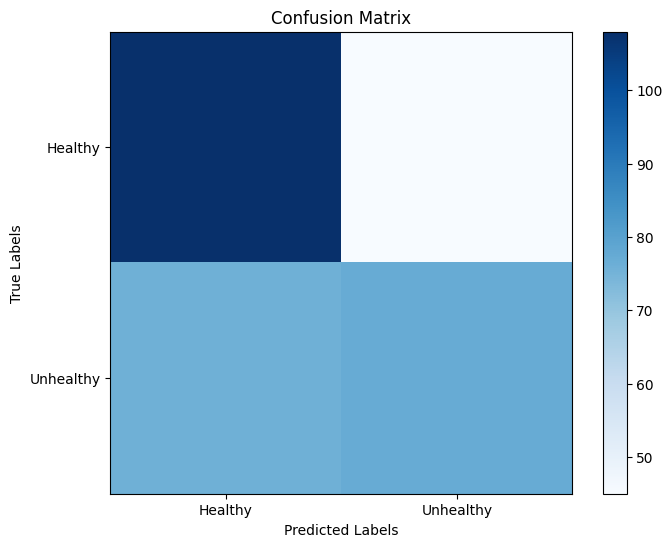

In [ ]:
report = classification_report(y_test, y_pred)
print(report)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, cmap='Blues', interpolation='nearest')
plt.title("Confusion Matrix")
plt.colorbar()
plt.xticks(np.arange(2), labels=['Healthy', 'Unhealthy'])
plt.yticks(np.arange(2), labels=['Healthy', 'Unhealthy'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


# Part 2: Neural Network Models

## CNN

In [ ]:
#peprocessing for CNN model
def preprocess_dataset(dataset, augment=False):
    features = []
    labels = []
    for batch, label_batch in dataset:
        if augment:  # Apply augmentation only for the training dataset
            batch = data_augmentation(batch)
        # Resize images to (64, 64)
        batch = tf.image.resize(batch, (64, 64))
        # Normalize images to [0, 1]
        batch = batch / 255.0
        features.append(batch)
        labels.append(label_batch)
    return tf.concat(features, axis=0), tf.concat(labels, axis=0)

X_train, y_train = preprocess_dataset(train_dataset, augment=True)
X_val, y_val = preprocess_dataset(validation_dataset, augment=False)
X_test, y_test = preprocess_dataset(test_dataset, augment=False)

print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")
print(f"Test data shape: {X_test.shape}")



Training data shape: (2142, 64, 64, 3)
Validation data shape: (612, 64, 64, 3)
Test data shape: (306, 64, 64, 3)


In [ ]:
from tensorflow.keras import layers, models

# Define the CNN architecture
cnn_model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),  # Updated input shape
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])




In [ ]:
# Compile the model
cnn_model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])


In [ ]:

# Display the model architecture
cnn_model.summary()


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_24 (Conv2D)                   │ (None, 62, 62, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_24 (MaxPooling2D)      │ (None, 31, 31, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_25 (Conv2D)                   │ (None, 29, 29, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_25 (MaxPooling2D)      │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_26 (Conv2D)                   │ (None, 12, 12, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_26 (MaxPooling2D)      │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_7 (Flatten)                  │ (None, 4608)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 128)                 │         589,952 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 683,329 (2.61 MB)

 Trainable params: 683,329 (2.61 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Define EarlyStopping
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss',    # Monitor validation loss
    patience=5,            # Stop training after 5 epochs with no improvement
    restore_best_weights=True  # Restore model weights from the epoch with the best validation loss
)


In [ ]:
# Train the model with EarlyStopping
history = cnn_model.fit(
    X_train, y_train,
    epochs=10,  # Set a high maximum number of epochs
    validation_data=(X_val, y_val),
    batch_size=32,
      # Add EarlyStopping here
)


Epoch 1/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 22s 327ms/step - accuracy: 0.6521 - loss: 0.6253 - val_accuracy: 0.6830 - val_loss: 0.5972
Epoch 2/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 36s 255ms/step - accuracy: 0.6263 - loss: 0.6279 - val_accuracy: 0.6127 - val_loss: 0.6384
Epoch 3/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 20s 255ms/step - accuracy: 0.6787 - loss: 0.6010 - val_accuracy: 0.6781 - val_loss: 0.5895
Epoch 4/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 20s 256ms/step - accuracy: 0.6714 - loss: 0.5932 - val_accuracy: 0.5882 - val_loss: 0.7048
Epoch 5/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 20s 251ms/step - accuracy: 0.6519 - loss: 0.6111 - val_accuracy: 0.6062 - val_loss: 0.6611
Epoch 6/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 21s 255ms/step - accuracy: 0.7227 - loss: 0.5420 - val_accuracy: 0.6062 - val_loss: 0.8034
Epoch 7/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 17s 256ms/step - accuracy: 0.7340 - loss: 0.5424 - val_accuracy: 0.6699 - val_loss: 0.6286
Epoch 8/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 22s 271ms/step - accuracy: 0.7389 - loss: 0.5202 - val_accu

In [ ]:
# Evaluate on the test data
val_loss, val_accuracy = cnn_model.evaluate(X_test, y_test)
print(f"Accuracy: {val_accuracy:.2f}")

# Generate predictions
y_pred = cnn_model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype("int32")


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - accuracy: 0.6958 - loss: 0.6157
Accuracy: 0.71
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step


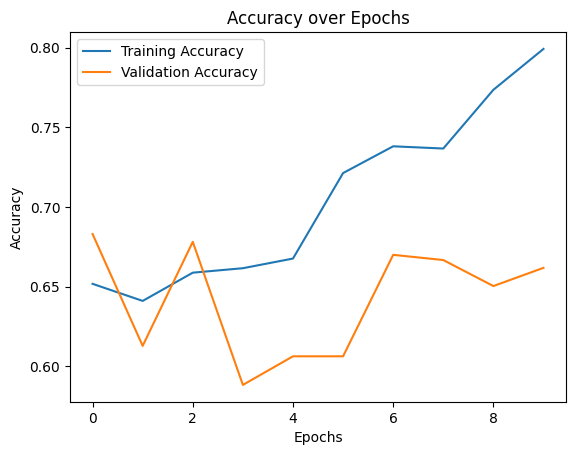

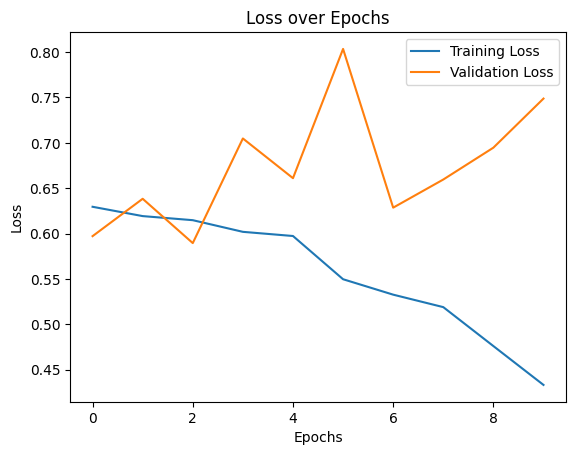

In [ ]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
# Generate a classification report
report = classification_report(y_test, y_pred_classes, target_names=['Healthy', 'Unhealthy'])
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

     Healthy       0.72      0.69      0.70       153
   Unhealthy       0.70      0.73      0.72       153

    accuracy                           0.71       306
   macro avg       0.71      0.71      0.71       306
weighted avg       0.71      0.71      0.71       306



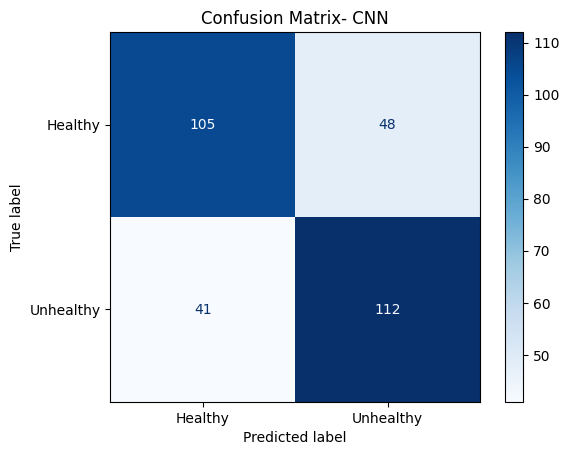

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Healthy', 'Unhealthy'])
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix- CNN')
plt.show()

## Transfer Learning

In [ ]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [ ]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


In [ ]:
base_model.trainable = False

In [ ]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_160"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 160, 160, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 80, 80, 32)     │            864 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 80, 80, 32)     │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 80, 80, 32)     │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 80, 80, 32)     │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 80, 80, 32)     │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 80, 80, 32)     │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 80, 80, 16)     │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 80, 80, 16)     │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 80, 80, 96)     │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 80, 80, 96)     │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 80, 80, 96)     │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 81, 81, 96)     │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 40, 40, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├──────────────────────

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 1,861,440 (7.10 MB)

 Non-trainable params: 396,544 (1.51 MB)

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [ ]:
prediction_layer = tf.keras.layers.Dense(1, activation='sigmoid')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [ ]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5, name='accuracy')])

In [ ]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

20/20 ━━━━━━━━━━━━━━━━━━━━ 17s 717ms/step - accuracy: 0.5308 - loss: 0.9686


In [ ]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.94
initial accuracy: 0.53


In [ ]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 234s 3s/step - accuracy: 0.4818 - loss: 0.8532 - val_accuracy: 0.5964 - val_loss: 0.6845
Epoch 2/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 98s 1s/step - accuracy: 0.5601 - loss: 0.7329 - val_accuracy: 0.6552 - val_loss: 0.6146
Epoch 3/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 147s 2s/step - accuracy: 0.6326 - loss: 0.6565 - val_accuracy: 0.7042 - val_loss: 0.5625
Epoch 4/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 140s 2s/step - accuracy: 0.6789 - loss: 0.6026 - val_accuracy: 0.7353 - val_loss: 0.5234
Epoch 5/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 137s 1s/step - accuracy: 0.7042 - loss: 0.5591 - val_accuracy: 0.7565 - val_loss: 0.4950
Epoch 6/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 144s 1s/step - accuracy: 0.7222 - loss: 0.5451 - val_accuracy: 0.7663 - val_loss: 0.4725
Epoch 7/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 160s 2s/step - accuracy: 0.7574 - loss: 0.5164 - val_accuracy: 0.7892 - val_loss: 0.4551
Epoch 8/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 115s 1s/step - accuracy: 0.7713 - loss: 0.4926 - val_accuracy: 0.7974 - va

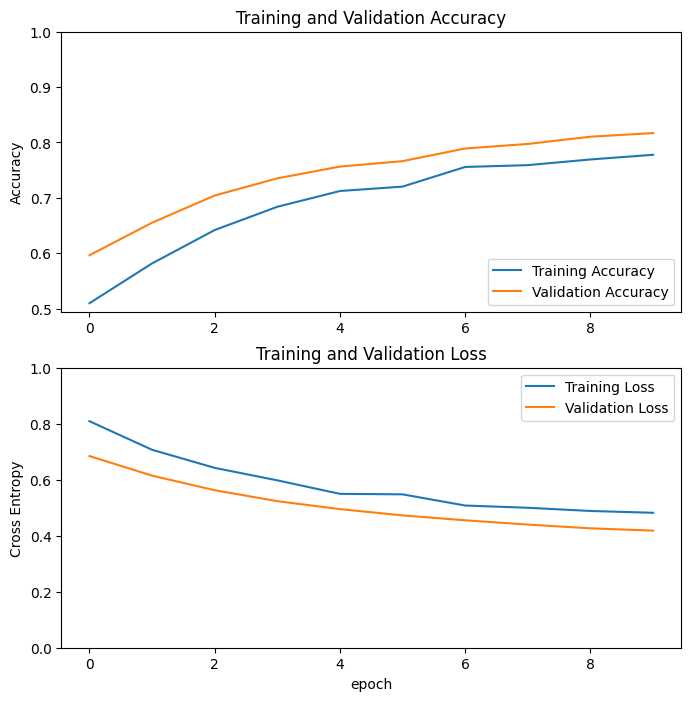

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
base_model.trainable = True

In [ ]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5, name='accuracy')])

In [ ]:
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 160, 160, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential (Sequential)              │ (None, 160, 160, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ true_divide_1 (TrueDivide)           │ (None, 160, 160, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ subtract_1 (Subtract)                │ (None, 160, 160, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_160 (Functional)    │ (None, 5, 5, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │           1,281 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,862,721 (7.11 MB)

 Non-trainable params: 396,544 (1.51 MB)

In [ ]:
len(model.trainable_variables)

56

In [ ]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=len(history.epoch),
                         validation_data=validation_dataset)

Epoch 11/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - accuracy: 0.5893 - loss: 0.7709 - val_accuracy: 0.6601 - val_loss: 0.6495
Epoch 12/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 140s 2s/step - accuracy: 0.7585 - loss: 0.4848 - val_accuracy: 0.7353 - val_loss: 0.5353
Epoch 13/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 140s 2s/step - accuracy: 0.8413 - loss: 0.3709 - val_accuracy: 0.7925 - val_loss: 0.4718
Epoch 14/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 145s 2s/step - accuracy: 0.8645 - loss: 0.3310 - val_accuracy: 0.8186 - val_loss: 0.4085
Epoch 15/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 143s 2s/step - accuracy: 0.8633 - loss: 0.3159 - val_accuracy: 0.8415 - val_loss: 0.3679
Epoch 16/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 140s 2s/step - accuracy: 0.8769 - loss: 0.2831 - val_accuracy: 0.8709 - val_loss: 0.3397
Epoch 17/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 137s 2s/step - accuracy: 0.8715 - loss: 0.2902 - val_accuracy: 0.8807 - val_loss: 0.3259
Epoch 18/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 144s 2s/step - accuracy: 0.8772 - loss: 0.2971 - val_accuracy: 0.

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

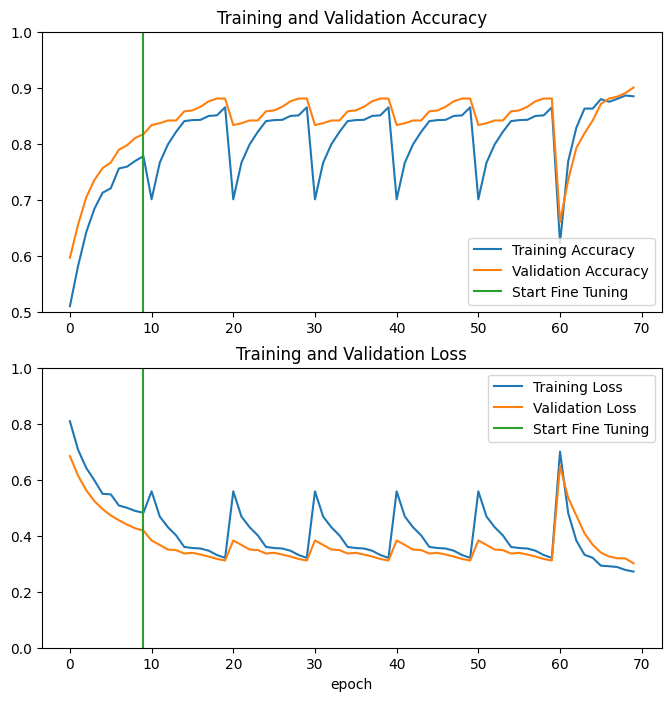

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.5, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

10/10 ━━━━━━━━━━━━━━━━━━━━ 58s 6s/step - accuracy: 0.8904 - loss: 0.2567
Test accuracy : 0.8856208920478821


Predictions:
 [0 1 1 1 0 0 1 1 0 1 0 0 0 0 0 1 0 1 0 0 0 0 1 1 0 0 0 1 1 0 0 1]
Labels:
 [0 1 1 1 0 0 1 1 1 1 0 0 0 1 0 1 0 1 0 0 0 1 1 1 0 0 0 1 1 1 1 1]


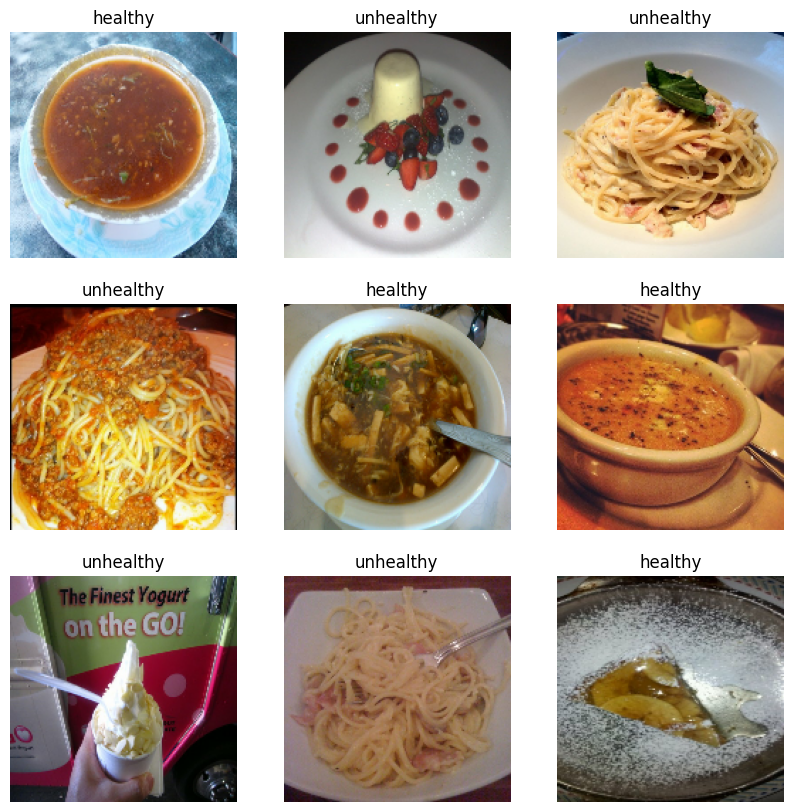

In [ ]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")